### Required Packages

In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
from scipy.stats import logistic
from os.path import join
from tqdm import tqdm
from PIL import Image
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, Lambda, Convolution2D, MaxPooling2D, Flatten
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50, preprocess_input
import os 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

import warnings
for i in [DeprecationWarning, FutureWarning, UserWarning]:
    warnings.filterwarnings("ignore", category=i)

/Users/yangzhenxiong/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/yangzhenxiong/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/yangzhenxiong/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 

### Define Parameter

In [2]:
batch_size = 24
embedding_dim = 50
image_size = 224
path_base = '../data/'
path_train = join(path_base, 'train')
path_test = join(path_base, 'test')
path_model = join(path_base, 'triplet_loss_model.hdf5')
path_csv = '../data/train.csv'

### Helping Function

In [3]:
class sample_gen(object):
    def __init__(self, file_class_mapping, other_class = "new_whale"):
        self.file_class_mapping = file_class_mapping
        self.class_to_list_files = defaultdict(list)
        self.list_other_class = []
        self.list_all_files = list(file_class_mapping.keys())
        self.range_all_files = list(range(len(self.list_all_files)))
        
        for file, class_ in file_class_mapping.items():
            if class_ == other_class:
                self.list_other_class.append(file)
            else:
                self.class_to_list_files[class_].append(file)     # 注意这里的 files 是一个 list，因为一个 class 可以对应多个 file
        self.list_classes = list(set(self.file_class_mapping.values()))  # 得到所有的 classes
        self.range_list_classes = range(len(self.list_classes))
        self.class_weight = np.array([len(self.class_to_list_files[class_]) for class_ in self.list_classes])
        self.class_weight = self.class_weight / np.sum(self.class_weight)    # 得到每一个 classes 的比例
        
    def get_sample(self):
        class_idx = np.random.choice(self.range_list_classes, 1, p=self.class_weight)[0]
        # 这里是随机选取一个 class_id，从对应的 class 的 files 中随机选两个。因为是同一个 class，所以是 positive。
        # 如果该 class 只有一个 file，那选取的就是同一个
        examples_class_idx = np.random.choice(range(len(self.class_to_list_files[self.list_classes[class_idx]])), 2)
        positive_example_1, positive_example_2 = \
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[0]], \
            self.class_to_list_files[self.list_classes[class_idx]][examples_class_idx[1]]
        negative_example = None
        while negative_example is None or self.file_class_mapping[negative_example] == \
            self.file_class_mapping[positive_example_1]:
            negative_example_idx = np.random.choice(self.range_all_files, 1)[0]
            negative_example = self.list_all_files[negative_example_idx]
            # 注意 while 循环，如果找的 negative 和 positive 是同一类将会一直循环下去
            return positive_example_1, negative_example, positive_example_2

def read_and_resize(filepath):
    im = Image.open(filepath).convert('RGB')
    im = im.resize((image_size, image_size))
    return np.array(im, dtype="float32")


def augment(im_array):
    if np.random.uniform(0, 1) > 0.9:
        im_array = np.fliplr(im_array)
    return im_array


def gen(triplet_gen):
    while True:
        list_positive_examples_1 = []
        list_negative_examples = []
        list_positive_examples_2 = []
        
        for i in range(batch_size):
            positive_example_1, negative_example, positive_example_2 = triplet_gen.get_sample()
            path_pos1 = join(path_train, positive_example_1)
            path_neg = join(path_train, negative_example)
            path_pos2 = join(path_train, positive_example_2)
            
            positive_example_1_img = read_and_resize(path_pos1)
            negative_example_img = read_and_resize(path_neg)
            positive_example_2_img = read_and_resize(path_pos2)
            
            positive_example_1_img = augment(positive_example_1_img)
            negative_example_img = augment(negative_example_img)
            positive_example_2_img = augment(positive_example_2_img)
            
            list_positive_examples_1.append(positive_example_1_img)
            list_negative_examples.append(negative_example_img)
            list_positive_examples_2.append(positive_example_2_img)
        
        A = preprocess_input(np.array(list_positive_examples_1))
        B = preprocess_input(np.array(list_positive_examples_2))
        C = preprocess_input(np.array(list_negative_examples))
        
        label = None
        
        yield({'anchor_input': A, 'positive_input': B, 'negative_input': C}, label)
        

In [4]:
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0., 1+loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)


def triplet_loss_np(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = np.square(anchor - positive)
    negative_distance = np.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = np.sqrt(np.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = np.sqrt(np.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = np.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = np.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = np.maximum(0., 1+loss)
    elif margin == 'softplus':
        loss = np.log(1 + K.exp(loss))
    return np.mean(loss)


def check_loss():
    batch_size = 10
    shape = (batch_size, 4096)
    
    p1 = normalize(np.random.random(shape))
    n = normalize(np.random.random(shape))
    p2 = normalize(np.random.random(shape))
    
    input_tensor = [K.variable(p1), K.variable(n), K.variable(p2)]
    out1 = K.eval(triplet_loss(input_tensor))
    input_np = [p1, n, p2]
    out2 = triplet_loss_np(input_np)
    
    assert out1.shape == out2.shape
    print(np.linalg.norm(out1))
    print(np.linalg.norm(out2))
    print(np.linalg.norm(out1 - out2))


In [5]:
check_loss()

1.0039337
1.0039336342687086
3.386788804959906e-08


### Model Design

In [15]:
def GetModel():
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='max')
    for layer in base_model.layers:
        layer.trainable = False
    
    x = base_model.output
    x = Dropout(0.6)(x)
    x = Dense(embedding_dim)(x)
    x = Lambda(lambda x: K.l2_normalize(x, axis=1))(x)
    embedding_model = Model(base_model.input, x, name='embedding')
    
    input_shape = (image_size, image_size, 3)
    anchor_input = Input(input_shape, name='anchor_input')
    positive_input = Input(input_shape, name='positive_input')
    negative_input = Input(input_shape, name='negative_input')
    
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embbeding = embedding_model(negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [anchor_embedding, positive_embedding, negative_embbeding]
    
    triplet_model = Model(inputs, outputs)
    triplet_model.add_loss(K.mean(triplet_loss(outputs)))
    
    return embedding_model, triplet_model

In [7]:
data = pd.read_csv(path_csv)
train, test = train_test_split(data, train_size = 0.7, random_state=42)
file_id_mapping_train = {k: v for k, v in zip(train.Image.values, train.Id.values)}
file_id_mapping_test = {k: v for k, v in zip(test.Image.values, test.Id.values)}
train_gen = gen(sample_gen(file_id_mapping_train))
test_gen = gen(sample_gen(file_id_mapping_test))

checkpoint = ModelCheckpoint(path_model, monitor='loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=2)
callbasks_list = [checkpoint, early]  # early

(224, 224, 3)


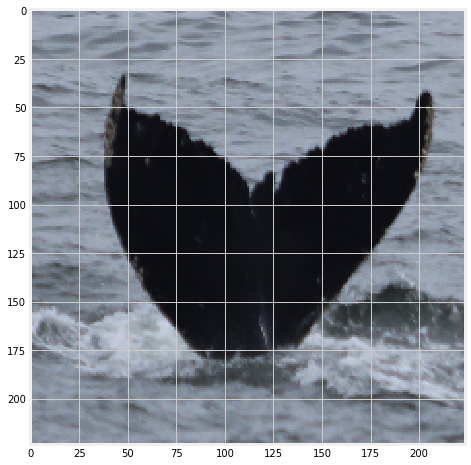

In [9]:
def ShowImg(img):
    plt.figure(figsize=(15, 8))
    plt.imshow(img.astype('uint8'))
    plt.show()
    plt.close()
    
batch = next(train_gen)

img = batch[0]['anchor_input'][0]
print(img.shape)
mean = [103.939, 116.779, 123.68]
img[..., 0] += mean[0]
img[..., 1] += mean[1]
img[..., 2] += mean[2]
img = img[..., ::-1]
ShowImg(img)

### Installation of Resnet50 Weight to keras

In [16]:
embedding_model, triplet_model = GetModel()

In [17]:
for i, layer in enumerate(embedding_model.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 conv1 False
2 bn_conv1 False
3 activation_99 False
4 max_pooling2d_3 False
5 res2a_branch2a False
6 bn2a_branch2a False
7 activation_100 False
8 res2a_branch2b False
9 bn2a_branch2b False
10 activation_101 False
11 res2a_branch2c False
12 res2a_branch1 False
13 bn2a_branch2c False
14 bn2a_branch1 False
15 add_33 False
16 activation_102 False
17 res2b_branch2a False
18 bn2b_branch2a False
19 activation_103 False
20 res2b_branch2b False
21 bn2b_branch2b False
22 activation_104 False
23 res2b_branch2c False
24 bn2b_branch2c False
25 add_34 False
26 activation_105 False
27 res2c_branch2a False
28 bn2c_branch2a False
29 activation_106 False
30 res2c_branch2b False
31 bn2c_branch2b False
32 activation_107 False
33 res2c_branch2c False
34 bn2c_branch2c False
35 add_35 False
36 activation_108 False
37 res3a_branch2a False
38 bn3a_branch2a False
39 activation_109 False
40 res3a_branch2b False
41 bn3a_branch2b False
42 activation_110 False
43 res3a_branch2c False
44 res3a_branc

In [18]:
for layer in embedding_model.layers[178:]:
    layer.trainable = True
for layer in embedding_model.layers[:178]:
    layer.trainable = False

In [22]:
triplet_model.compile(loss=None, optimizer=Adam(0.01))
history = triplet_model.fit_generator(train_gen, 
                                     validation_data=test_gen, 
                                     epochs=4, 
                                     verbose=1,
                                     workers=6,
                                     steps_per_epoch=5,   # 200                                  
                                     validation_steps=10, # 20
                                     use_multiprocessing=True)

Epoch 1/4
5/5 [==============================] - 241s - loss: 0.8753 - val_loss: 0.4343
Epoch 2/4
5/5 [==============================] - 237s - loss: 0.7513 - val_loss: 0.4232
Epoch 3/4
5/5 [==============================] - 231s - loss: 0.8039 - val_loss: 0.4257
Epoch 4/4
5/5 [==============================] - 229s - loss: 0.7538 - val_loss: 0.3900


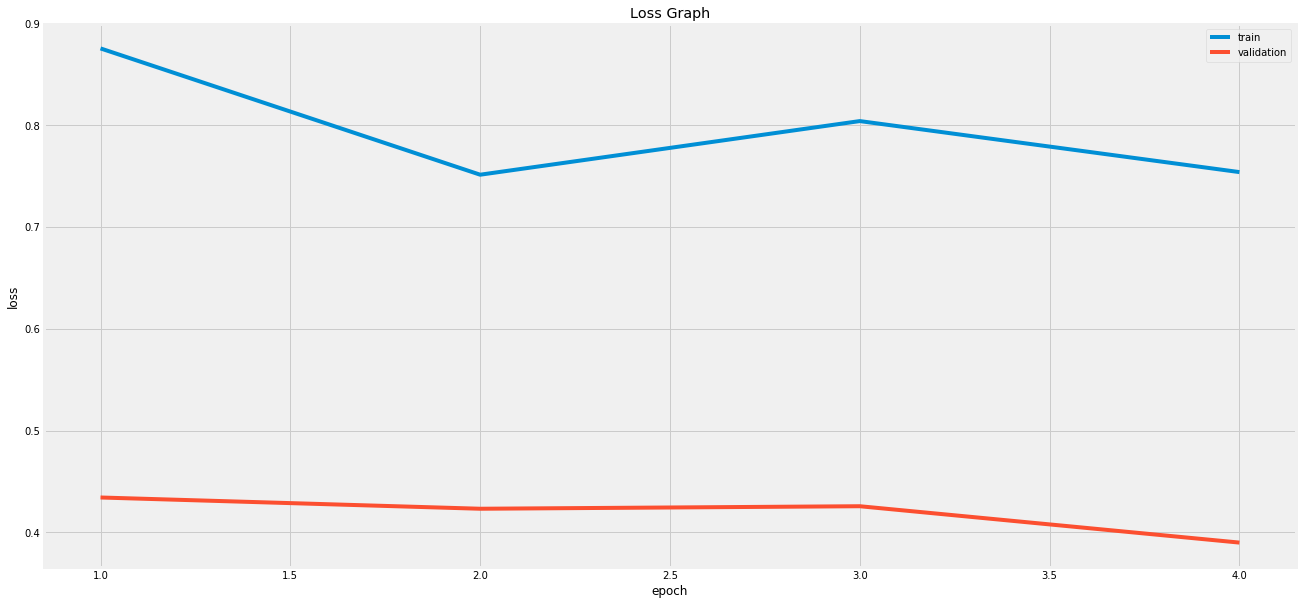

In [30]:
def eval_plot(history, epoch):
    plt.figure(figsize=(20, 10))
    sns.lineplot(range(1, epoch+1), history.history['loss'], label='Train loss')
    sns.lineplot(range(1, epoch+1), history.history['val_loss'], label='Valid loss')
    plt.legend(['train', 'validation'], loc='uppper left')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Loss Graph')
    plt.show()

eval_plot(history, 4)    

In [31]:
for layer in embedding_model.layers[150:]:
    layer.trainable = True
for layer in embedding_model.layers[:150]:
    layer.trainable = False
triplet_model.compile(loss=None, optimizer=Adam(0.0001))
history = triplet_model.fit_generator(train_gen,
                                     validation_data = test_gen,
                                     epochs=3,
                                     verbose=1,
                                     workers=6,
                                     steps_per_epoch=10, #70
                                     validation_steps=5, #30
                                     use_multiprocessing=True)

Epoch 1/3
10/10 [==============================] - 247s - loss: 0.8132 - val_loss: 0.3548
Epoch 2/3
10/10 [==============================] - 241s - loss: 0.7774 - val_loss: 0.3530
Epoch 3/3
10/10 [==============================] - 248s - loss: 0.7116 - val_loss: 0.2406


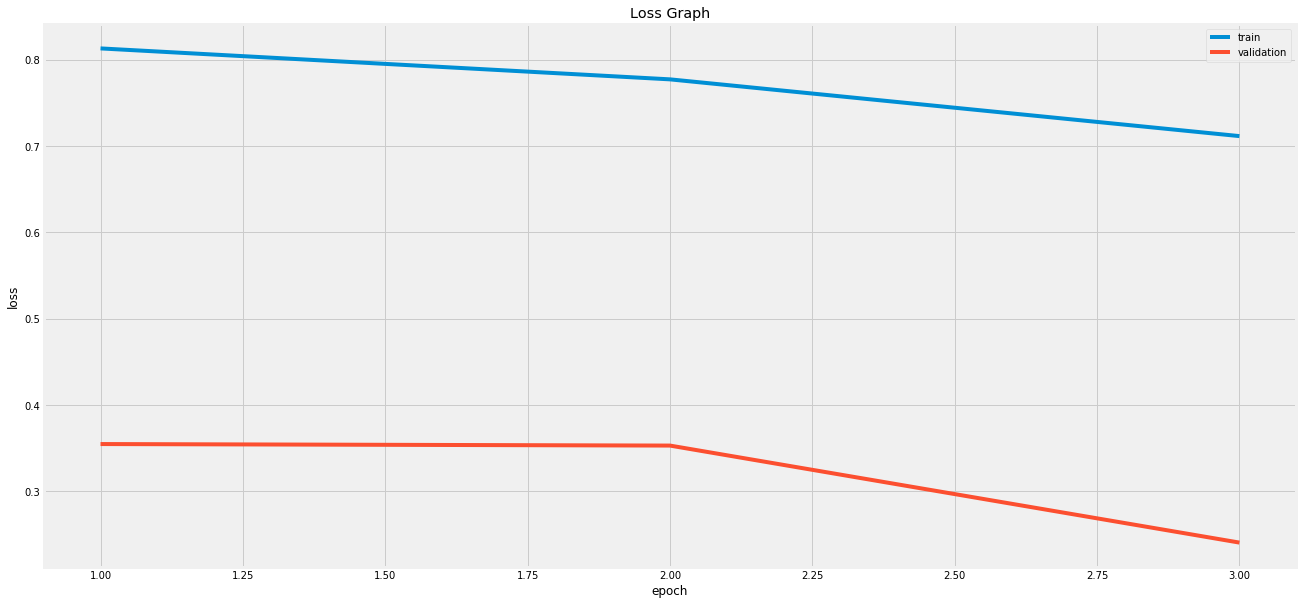

In [33]:
eval_plot(history, 3)

In [34]:
def data_generator(fpaths, batch=16):
    i = 0
    imgs = []
    fnames = []
    for path in fpaths:
        if i == 0:
            imgs = []     # 为什么还要再写一次
            fnames = []
        i += 1
        img = read_and_resize(path)
        imgs.append(img)
        fnames.append(os.path.basename(path))
        if i == batch:
            i = 0
            imgs = np.array(imgs)
            yield fnames, imgs
    
    if i != 0:
        imgs = np.array(imgs)
        yield fnames, imgs
    
    raise StopIteration()

In [36]:
data = pd.read_csv(path_csv)
file_id_mapping = {k:v for k, v in zip(data.Image.values, data.Id.values)}
from glob import glob
train_files = glob(join(path_train, '*.jpg'))
test_files = glob(join(path_test, '*.jpg'))

In [ ]:
train_preds = []
train_file_names = []
for fnames, imgs in tqdm(data_generator(train_files, batch=32)):
    predicts = embedding_model.predict(imgs)
    predicts = predicts.tolist()
    train_preds += predicts
    train_file_names += fnames
train_preds = np.array(train_preds)

In [1]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=6)
neigh.fit(train_preds)

In [ ]:
distance_test, neighbors_test = neigh.kneighbors(test_preds)
distance_test, neighbors_test = distance_test.tolist(), neighbors_test.tolist()

In [ ]:
preds_str = []

for filepath, distance, neighbour_ in zip(test_file_names, distances_test, neighbour_test):
    sample_result = []
    sample_classes = []
    for d, n in zip(distance, neighbour_):
        train_file = train_files[n].split(os.sep)[-1]
        class_train = file_id_mapping[train_file]
        sample_classes.append(class_train)
        sample_result.append((class_train, d))
        
    if "new_whale" not in sample_classes:
        sample_result.sort(key=lamda x: x[1])
        sample_result = sample_result[:5]
        preds_str.append(" ".join(x[0] for x in sample_result))

In [ ]:
preds_str

In [ ]:
df = pd.DataFrame(preds_str, columns=["Id"])
df['Image'] = [x.split(os.sep)[-1] for x in test_file_names]
df.to_csv("sub_humpback.csv", index=False)